# Predicting MBTI Based on Social Media Use
#### ECON 323 003 Quantitative Economic Modelling with Data Science Application

Group Members: Zaya Baatarzaya (45131414) | Kim Tan Palanca (98857568) | Vivian Vu (92958461) | Sophia Zhang (65921389)

# Introduction

Personality is defined as the characteristics and behavior of an individual that encompass their emotional patterns (American Psychology Association, 2022). Over time, many mechanisms and indicators have been discovered that break down the intricacies of a personality into general categories, one of which is the Myers-Briggs Type Indicator (MBTI) test. This personality instrument was developed by Isabel Briggs Myers and Katherine Briggs to bring true Carl Jung’s theory of personalities having basic differences.

There are four main divisions within the MBTI classification with two contrasting traits in each division. Depending on the traits satisfied by an individual, a four-letter code that combines one trait from each of the divisions will determine the individual’s personality type. The divisions and types are listed as follows:

**Table 1.** <br>
*Myers-Briggs Type Indicators*</p>


Category  | Traits | Description
------------- | ------------- | -------------
Favorite World  | Introvert (I) or Extrovert (E) |Preference to focus on the outer world or one’s inner world.
Information  | Sensing (S) or Intuition (N) | Preference to focus on and take in basic information or to interpret and add meaning.
Decisions | Thinking (T) or Feeling (F) |Preference to first look at logic and consistency or to first look at the people and special circumstances when making decisions.
Structure | Judging (J) or Perceiving (P) | Preference to get things decided or to stay open to new information and options when dealing with the outside world.

Note. The information in this table is taken from The Myers & Briggs Foundation. (2022, November). MBTI® basics. The Myers & Briggs Foundation. Retrieved April 3, 2023, from https://www.myersbriggs.org/my-mbti-personality-type/mbti-basics/ 

There are many aspects of one’s behavior that determine their personality type including their writing style (Gupta et al., 2019). With the popularity of social media where people have the freedom to share their thoughts and stories, many individuals of varying personality types can arise in a single social media platform (Nisha et al., 2021). The dataset “(MBTI) Myers-Briggs Personality Type Dataset” by user Mitchell J presents data collected from the PersonalityCafe Forum which includes an individual’s MBTI and their last 50 posts on the forum. Utilizing the techniques learned in the ECON 323 course, this project aims to delve into the relationship between Myers Briggs Type Indicators (MBTI) and social media use. More specifically, to predict an individual’s MBTI based on their posts on social media.


# Cleaning

Before performing any analysis, it is critical to import the dataset and any packages used throughout the study. As mentioned in the introduction, the project will manipulate the “(MBTI) Myers-Briggs Personality Type Dataset” by user Mitchell J. Note that we first separated the original data set into two CSV files: one with only the MBTI type and another with only the posts. We then imported the two files into this notebook.

In [57]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import (linear_model, metrics, neural_network, pipeline, preprocessing, model_selection)

from bs4 import BeautifulSoup
import nltk
import string
from nltk.tokenize import RegexpTokenizer

types = pd.read_csv("mbti_types.csv")
posts = pd.read_csv("mbti_posts.csv")

A section of each file is shown below:

In [17]:
print(types.head(10))
print(posts.head(10))

   type
0  INFJ
1  ENTP
2  INTP
3  INTJ
4  ENTJ
5  INTJ
6  INFJ
7  INTJ
8  INFJ
9  INTP
                                               posts
0  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  'I'm finding the lack of me in these posts ver...
2  'Good one  _____   https://www.youtube.com/wat...
3  'Dear INTP,   I enjoyed our conversation the o...
4  'You're fired.|||That's another silly misconce...
5  '18/37 @.@|||Science  is not perfect. No scien...
6  'No, I can't draw on my own nails (haha). Thos...
7  'I tend to build up a collection of things on ...
8  I'm not sure, that's a good question. The dist...
9  'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


The analysis will only utilize the first post of each subject, thus each row in the `posts` CSV file will be seaparated by `"|||"`. Then, only the first column will be selected for the continuation of the investigation.

In [18]:
sep_posts = posts['posts'].str.split("\|\|\|", expand = True)
sample_posts = pd.DataFrame(sep_posts[0])

Lastly, the two files--`types` and `sample_posts`-- will concatenate into one dataframe using the `pd.concat` function.

In [19]:
data = pd.concat([types, sample_posts], axis=1)
data.columns = ['type', 'posts']
data

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


Given the large number of observations in the dataset, it is beneficial first to understand the distribution of representation for each MBTI type to provide some awareness of any possible uneven distribution when concluding the analysis.

In [20]:
mbti_types = ['estj', 'entj', 'esfj', 'enfj', 
              'istj', 'isfj', 'intj', 'infj',
              'estp', 'entp', 'esfp', 'enfp', 
              'istp', 'intp', 'isfp', 'infp']

mbti=[]
for x in mbti_types:
    l = x.upper()
    mbti += [l]

print(mbti)

['ESTJ', 'ENTJ', 'ESFJ', 'ENFJ', 'ISTJ', 'ISFJ', 'INTJ', 'INFJ', 'ESTP', 'ENTP', 'ESFP', 'ENFP', 'ISTP', 'INTP', 'ISFP', 'INFP']


In [21]:
group_data = data.groupby('type')

n = []
for x in mbti:
    num_rows = len(group_data.get_group(f"{x}"))
    n += [num_rows]
    
print(n)

[39, 231, 42, 190, 205, 166, 1091, 1470, 89, 685, 48, 675, 337, 1304, 271, 1832]


In [22]:
n_obs = pd.DataFrame([np.array(mbti), np.array(n)]).T

In [23]:
n_obs.columns = ["type", "n obeservations"]

n_obs

,type,n obeservations
0,ESTJ,39
1,ENTJ,231
2,ESFJ,42
3,ENFJ,190
4,ISTJ,205
5,ISFJ,166
6,INTJ,1091
7,INFJ,1470
8,ESTP,89
9,ENTP,685


In [24]:
n_obs.sum()

type               ESTJENTJESFJENFJISTJISFJINTJINFJESTPENTPESFPEN...
n obeservations                                                 8675
dtype: object

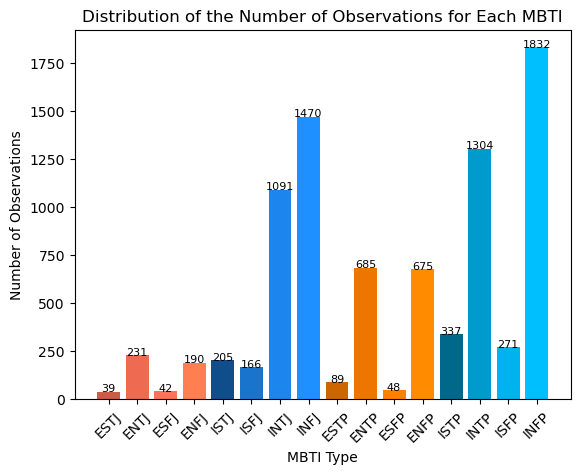

In [29]:
colors = ['#cd5b45', '#ee6a50','#ff7256', '#ff7f50', 
          '#104e8b', '#1874cd', '#1c86ee', '#1e90ff', 
          '#cd6600','#ee7600', '#ff7f00', '#ff8c00',
          '#00688b', '#009acd', '#00b2ee', '#00bfff']

def bar_labels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha = "center", fontsize=8)

plt.bar(n_obs["type"], n_obs["n obeservations"], width = 0.8, color = colors)
plt.xlabel("MBTI Type")
plt.ylabel("Number of Observations")
plt.xticks(rotation = 45)
plt.title("Distribution of the Number of Observations for Each MBTI")

bar_labels(n_obs["type"], n_obs["n obeservations"])

From this graph, it should be noted that there is a larger representation of the INTJ, INFJ, INTP, and INFP types while a much smaller representation of the ESTJ,ESFJ,ESTP, and ESFP types.

# Analysis

### Dividing testing and training

In [30]:
train, test = model_selection.train_test_split(data, test_size=0.3, random_state = 301)

### Visualizing the Training Data Distribution

In [31]:
train

,type,posts
3938,ISTP,'The ISTPs quiet moments didnt seem to bother ...
5687,INTP,'ok thank you!
3331,ISTP,':wink:
7116,INTP,"'Alright, I'm just bored. So I thought up a ga..."
1425,INFP,'Golden
...,...,...
2365,INFP,"'Not married, but I would to either elope or h..."
4331,INTJ,"'So my sick, stiff and introverted self starte..."
3730,INTP,My son and I doing our mad faces at his birth ...
1604,ENTP,'Any place with craft beers. And sometimes mus...


In [32]:
group_train = train.groupby('type')

n_train = []
for x in mbti:
    num_rows_train = len(group_train.get_group(f"{x}"))
    n_train += [num_rows_train]
    
print(n_train)

[30, 173, 31, 141, 143, 101, 780, 1006, 59, 479, 35, 473, 232, 911, 183, 1295]


In [33]:
n_obs_train = pd.DataFrame([np.array(mbti), np.array(n_train)]).T
n_obs_train.columns = ["type", "n obeservations"]

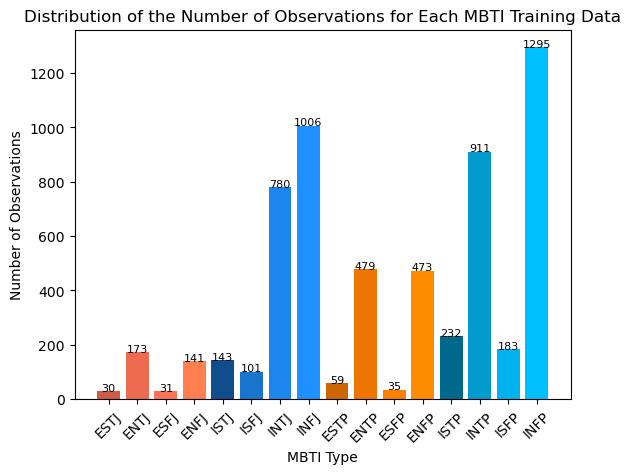

In [34]:
plt.bar(n_obs_train["type"], n_obs_train["n obeservations"], width = 0.8, color = colors)
plt.xlabel("MBTI Type")
plt.ylabel("Number of Observations")
plt.xticks(rotation = 45)
plt.title("Distribution of the Number of Observations for Each MBTI Training Data")

bar_labels(n_obs_train["type"], n_obs_train["n obeservations"])

### Word Counts of Posts from Each MBTI

In [59]:
intj_train = group_train.get_group('INTJ')
intj_posts = intj_train['posts']

num_words = []
for x in range(len(intj_posts)):
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(intj_posts.iloc[x])
    num_words += [len(tokens)]

    
print(num_words) 



[27, 21, 19, 38, 42, 31, 15, 38, 27, 36, 35, 12, 23, 9, 21, 33, 38, 5, 1, 30, 37, 25, 35, 21, 37, 37, 41, 35, 26, 35, 7, 12, 36, 35, 6, 39, 42, 42, 33, 34, 38, 40, 27, 42, 35, 3, 20, 40, 29, 22, 28, 34, 41, 38, 13, 41, 38, 37, 30, 32, 24, 18, 24, 19, 9, 6, 38, 16, 37, 38, 15, 33, 31, 42, 26, 38, 8, 2, 6, 36, 39, 14, 38, 36, 17, 40, 27, 37, 34, 18, 29, 39, 14, 34, 31, 36, 41, 4, 2, 12, 36, 35, 4, 1, 26, 37, 34, 36, 41, 35, 7, 40, 36, 35, 39, 41, 30, 11, 37, 28, 44, 13, 22, 34, 33, 20, 42, 0, 41, 33, 5, 37, 39, 28, 34, 36, 9, 15, 12, 39, 7, 37, 39, 33, 38, 11, 34, 15, 37, 31, 13, 32, 7, 8, 11, 24, 8, 25, 40, 37, 35, 15, 42, 33, 31, 36, 34, 41, 44, 37, 13, 6, 37, 40, 42, 33, 40, 37, 3, 7, 9, 6, 36, 10, 7, 38, 43, 3, 2, 38, 40, 13, 14, 14, 21, 23, 28, 32, 34, 33, 11, 41, 34, 7, 32, 35, 6, 14, 31, 13, 23, 1, 9, 40, 16, 7, 19, 37, 38, 7, 38, 2, 15, 42, 31, 9, 4, 7, 40, 8, 7, 2, 34, 36, 1, 32, 7, 12, 16, 42, 3, 8, 7, 23, 41, 27, 6, 28, 37, 37, 40, 35, 28, 43, 7, 31, 38, 36, 32, 35, 37, 7, 37,